In [30]:
import argparse
import os
import torch
import pyro
import json
import math
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import PyroOptim
from torch.optim import Adam
import pyro.distributions as dist
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.cm import get_cmap
from scipy.sparse import csr_matrix

import numpy as np
import pandas as pd
import anndata as ad
import scanpy as sc
import lightning as L
import torch.nn.functional as F

import subprocess
import warnings
warnings.filterwarnings("ignore")
from importlib import reload

# this ensures that I can update the class without losing my variables in my notebook
import xenium_cluster
reload(xenium_cluster)
from xenium_cluster import XeniumCluster
from utils.metrics import *

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [31]:
def prepare_DLPFC_data(
    section_id=151670,
    num_pcs=5,
    log_normalize=True,
):
    section = ad.read_h5ad(f"data/DLPFC/{section_id}.h5ad")
    section.var["feature_name"] = section.var.index

    spatial_locations = section.obs[["array_row", "array_col"]]
    spatial_locations.columns = ["row", "col"]

    clustering = XeniumCluster(data=section.X, dataset_name="DLPFC")
    clustering.xenium_spot_data = section
    if log_normalize:
        clustering.xenium_spot_data.X = np.log1p(clustering.xenium_spot_data.X)

    sc.tl.pca(clustering.xenium_spot_data, svd_solver='arpack', n_comps=num_pcs)
    data = clustering.xenium_spot_data.obsm["X_pca"]

    return data, spatial_locations, clustering

In [32]:
def prepare_Xenium_data(
        dataset="hBreast", 
        spots=True, 
        spot_size=100, 
        third_dim=False, 
        log_normalize=True,
        likelihood_mode="PCA",
        num_pcs=5,
        hvg_var_prop=0.5,
        min_expressions_per_spot=10
    ):

    data_filepath = f"data/spot_data/{dataset}/hBreast_SPOTSIZE={spot_size}um_z={third_dim}.h5ad"
    
    if spots:

        if os.path.exists(data_filepath):

            clustering = XeniumCluster(data=None, dataset_name="hBreast")
            clustering.set_spot_size(spot_size)
            print("Loading data.")
            clustering.xenium_spot_data = ad.read_h5ad(data_filepath)

        else:

            # Path to your .gz file
            file_path = f'data/{dataset}/transcripts.csv.gz'

            # Read the gzipped CSV file into a DataFrame
            df_transcripts = pd.read_csv(file_path, compression='gzip')
            df_transcripts["error_prob"] = 10 ** (-df_transcripts["qv"]/10)
            df_transcripts.head(), df_transcripts.shape

            # drop cells without ids
            df_transcripts = df_transcripts[df_transcripts["cell_id"] != -1]

            # drop blanks and controls
            df_transcripts = df_transcripts[~df_transcripts["feature_name"].str.startswith('BLANK_') & ~df_transcripts["feature_name"].str.startswith('NegControl')]

            clustering = XeniumCluster(data=df_transcripts, dataset_name="hBreast")
            clustering.set_spot_size(spot_size)

            if not os.path.exists(data_filepath):
                print("Generating and saving data")
                clustering.create_spot_data(third_dim=third_dim, save_data=True)
                clustering.xenium_spot_data.write_h5ad(data_filepath)

        print("Number of spots: ", clustering.xenium_spot_data.shape[0])
        clustering.xenium_spot_data = clustering.xenium_spot_data[clustering.xenium_spot_data.X.sum(axis=1) > min_expressions_per_spot]
        print("Number of spots after filtering: ", clustering.xenium_spot_data.shape[0])

        if log_normalize:
            clustering.normalize_counts(clustering.xenium_spot_data)

        if likelihood_mode == "PCA":
            sc.tl.pca(clustering.xenium_spot_data, svd_solver='arpack', n_comps=num_pcs)
            data = clustering.xenium_spot_data.obsm["X_pca"]
        elif likelihood_mode == "HVG":
            min_dispersion = torch.distributions.normal.Normal(0.0, 1.0).icdf(hvg_var_prop)
            clustering.filter_only_high_variable_genes(clustering.xenium_spot_data, flavor="seurat", min_mean=0.0125, max_mean=1000, min_disp=min_dispersion)
            clustering.xenium_spot_data = clustering.xenium_spot_data[:,clustering.xenium_spot_data.var.highly_variable==True]
            data = clustering.xenium_spot_data.X
        elif likelihood_mode == "ALL":
            data = clustering.xenium_spot_data.X

        spatial_locations = clustering.xenium_spot_data.obs[["row", "col"]]
    
    # prepare cells data
    else:

        cells = df_transcripts.groupby(['cell_id', 'feature_name']).size().reset_index(name='count')
        cells_pivot = cells.pivot_table(index='cell_id', 
                                        columns='feature_name', 
                                        values='count', 
                                        fill_value=0)
        
        location_means = df_transcripts.groupby('cell_id').agg({
            'x_location': 'mean',
            'y_location': 'mean',
            'z_location': 'mean'
        }).reset_index()

        cells_pivot = location_means.join(cells_pivot, on='cell_id')

        if log_normalize:
            # log normalization
            cells_pivot.iloc[:, 4:] = np.log1p(cells_pivot.iloc[:, 4:])

        if likelihood_mode == "PCA":
            pca = PCA(n_components=num_pcs)
            data = pca.fit_transform(cells_pivot.iloc[:, 4:])

        elif likelihood_mode == "HVG":
            genes = cells_pivot.iloc[:, 4:]
            gene_variances = genes.var(axis=0)
            gene_variances = gene_variances.sort_values(ascending=False)
            gene_var_proportions = (gene_variances / sum(gene_variances))
            relevant_genes = list(gene_var_proportions[(gene_var_proportions.cumsum() < hvg_var_prop)].index)
            cells_pivot.iloc[:, 4:] = cells_pivot.iloc[:, 4:][[relevant_genes]]
            data = cells_pivot.iloc[:, 4:]

        elif likelihood_mode == "ALL":
            data = cells_pivot.iloc[:, 4:]

        spatial_locations = cells_pivot[["x_location", "y_location"]]


    return data, spatial_locations, clustering # the last one is to regain var/obs access from original data

In [33]:
DATA_TYPE = "XENIUM"
dataset_name = "hBreast"
data_mode = "PCA"
spot_size = 50
num_pcs = 25
hvg_var_prop = 0.9
num_clusters = 15
concentration_amplification = 5
sample_for_assignment = True
kmeans_init = True
neighborhood_size = 2
spatial_init = True
spatial_normalize = 1.0
batch_size = 16
neighborhood_agg = "sum"
uncertainty_values = [0.25, 0.5, 0.75, 0.9, 0.99]
evaluate_markers = False
min_expressions_per_spot = 250

In [34]:
def save_filepath(model, component):

    total_file_path = (
        f"results/{dataset_name}/{model}/{component}/{data_file_path}/"
        f"KMEANSINIT={kmeans_init}/NEIGHBORSIZE={neighborhood_size}/NUMCLUSTERS={num_clusters}"
        f"/SPATIALINIT={spatial_init}/SAMPLEFORASSIGNMENT={sample_for_assignment}"
        f"/SPATIALNORM={spatial_normalize}/SPATIALPRIORMULT={concentration_amplification}/SPOTSIZE={spot_size}/AGG={neighborhood_agg}"
    )

    return total_file_path

In [35]:
if DATA_TYPE == "XENIUM":
    # Call prepare_Xenium_data with the appropriate arguments
    gene_data, spatial_locations, original_adata = prepare_Xenium_data(
        dataset="hBreast", 
        spots=True, 
        spot_size=spot_size, 
        third_dim=False, 
        log_normalize=True, 
        likelihood_mode=data_mode, 
        num_pcs=num_pcs,
        hvg_var_prop=hvg_var_prop,
        min_expressions_per_spot=min_expressions_per_spot
    )
elif DATA_TYPE == "DLPFC":
    gene_data, spatial_locations, original_adata = prepare_DLPFC_data(
        section_id=151507,
        num_pcs=num_pcs,
    )


Loading data.
Number of spots:  23444
Number of spots after filtering:  18699


torch.Size([18699, 25])


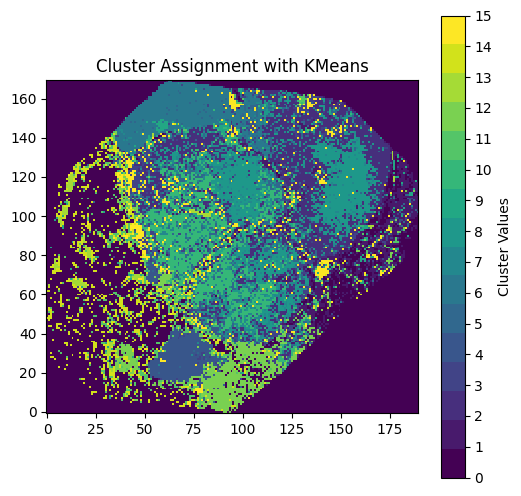

In [36]:
# Clear the param store in case we're in a REPL
pyro.clear_param_store()

spatial_init_data = gene_data
empirical_prior_means = torch.ones(num_clusters, spatial_init_data.shape[1])
empirical_prior_scales = torch.ones(num_clusters, spatial_init_data.shape[1])

if spatial_init:

    spatial_init_data = np.concatenate((spatial_locations, gene_data), axis=1)

    if spatial_normalize:

        spatial_init_data = StandardScaler().fit_transform(spatial_init_data)
        spatial_init_data[:, :spatial_locations.shape[1]] *= spatial_normalize

if kmeans_init:

    kmeans = KMeans(n_clusters=num_clusters).fit(spatial_init_data)

    initial_clusters = kmeans.predict(spatial_init_data)
    for i in range(num_clusters):
        empirical_prior_means[i] = torch.tensor(spatial_init_data[initial_clusters == i, spatial_locations.shape[1]:].mean(axis=0))
        empirical_prior_scales[i] = torch.tensor(spatial_init_data[initial_clusters == i, spatial_locations.shape[1]:].std(axis=0))
    
    rows = spatial_locations["row"].astype(int)
    columns = spatial_locations["col"].astype(int)

    num_rows = int(max(rows) - min(rows) + 1)
    num_cols = int(max(columns) - min(columns) + 1)

    cluster_grid = torch.zeros((num_rows, num_cols), dtype=torch.int)

    cluster_grid[rows, columns] = torch.tensor(initial_clusters) + 1

    colors = plt.cm.get_cmap('viridis', num_clusters + 1)
    colormap = ListedColormap(colors(np.linspace(0, 1, num_clusters + 1)))

    plt.figure(figsize=(6, 6))
    plt.imshow(cluster_grid, cmap=colormap, interpolation='nearest', origin='lower')
    plt.colorbar(ticks=range(num_clusters + 1), label='Cluster Values')
    plt.title('Cluster Assignment with KMeans')

    match data_mode:
        case "PCA":
            data_file_path = f"{data_mode}/{num_pcs}"
        case "HVG": 
            data_file_path = f"{data_mode}/{hvg_var_prop}"
        case "ALL":
            data_file_path = f"{data_mode}"
        case _:
            raise ValueError("The data mode specified is not supported.")

    if not os.path.exists(bayxensmooth_clusters_filepath := save_filepath("KMeans", "clusters")):
        os.makedirs(bayxensmooth_clusters_filepath)
    plt.savefig(
        f"{bayxensmooth_clusters_filepath}/result.png"
    )

    if dataset_name == "DLPFC":
        # Create a DataFrame for easier handling
        data = pd.DataFrame({
            'ClusterAssignments': initial_clusters,
            'Region': original_adata.xenium_spot_data.obs["Region"]
        })

        # Drop rows where 'Region' is NaN
        filtered_data = data.dropna(subset=['Region'])

        # Calculate ARI and NMI only for the non-NaN entries
        ari = ARI(filtered_data['ClusterAssignments'], filtered_data['Region'])
        nmi = NMI(filtered_data['ClusterAssignments'], filtered_data['Region'])
        cluster_metrics = {
            "ARI": ari,
            "NMI": nmi
        }

    data_file_path = f"{data_mode}/{num_pcs}"

    # Calculate WSS for KMeans clusters
    wss = {}
    for label in range(1, num_clusters + 1):
        current_cluster_locations = torch.stack(torch.where((cluster_grid == label)), axis=1).to(float)
        wss[f"Cluster {label}"] = (spot_size ** 2) * torch.mean(torch.cdist(current_cluster_locations, current_cluster_locations)).item()

    if not os.path.exists(kmeans_wss_filepath := save_filepath("KMeans", "wss")):
        os.makedirs(kmeans_wss_filepath)
    with open(f"{kmeans_wss_filepath}/wss.json", 'w') as fp:
        json.dump(wss, fp)

    concentration_priors = torch.tensor(pd.get_dummies(initial_clusters, dtype=float).to_numpy())

else:

    concentration_priors = torch.ones((len(gene_data), num_clusters), dtype=float)

concentration_w_locations = torch.cat((torch.tensor(spatial_locations.to_numpy()), concentration_priors), dim=1)

# Clone to avoid modifying the original tensor
spatial_concentration_priors = concentration_priors.clone()
# Number of features in the concentration data
num_features = concentration_priors.shape[1]

# Compute the number of elements in each dimension
num_elements = concentration_priors.shape[0]

# Precompute all distance pairs between locations
dist_x = torch.abs(concentration_w_locations[:, None, 0] - concentration_w_locations[None, :, 0])
dist_y = torch.abs(concentration_w_locations[:, None, 1] - concentration_w_locations[None, :, 1])

# Compute neighborhood mask based on the neighborhood size
mask = (dist_x <= neighborhood_size) & (dist_y <= neighborhood_size)

if neighborhood_agg not in ["sum", "mean"]:
    def weighting_function(x):
        return torch.where(x != 0, 1 / (x ** 1.5), torch.zeros_like(x)).reshape(-1,1)
    distances_in_neighborhood = (dist_x + 1) * (dist_x <= neighborhood_size) + (dist_y + 1) * (dist_y <= neighborhood_size)

# Apply the mask to compute the sum of the neighborhood
for i in range(num_elements):
    # Select the mask for the current element
    current_mask = mask[i]
    # Compute the sum of elements in the neighborhood
    if neighborhood_agg == "sum":
        neighborhood_expression = concentration_priors[current_mask].sum(dim=0)
    elif neighborhood_agg == "mean":
        neighborhood_expression = concentration_priors[current_mask].mean(dim=0)
    else:
        weighted_A = weighting_function(distances_in_neighborhood[i][current_mask])
        neighborhood_expression = (weighted_A * concentration_priors[current_mask]).sum(dim=0)

    # Update the spatial concentration priors with the mean or sum as required
    spatial_concentration_priors[i] += neighborhood_expression

concentration_priors = spatial_concentration_priors
concentration_priors += torch.distributions.half_normal.HalfNormal(0.1).sample((concentration_priors.shape))
concentration_priors /= concentration_priors.sum(dim=1).unsqueeze(1)
concentration_priors *= concentration_amplification

# Load the data
data = torch.tensor(gene_data).float()
print(data.shape)

In [37]:
def model(data):
    
    # Define the means and variances of the Gaussian components
    with pyro.plate('clusters', num_clusters):
        cluster_means = pyro.sample("cluster_means", dist.Normal(empirical_prior_means, 1.0).to_event(1))
        cluster_scales = pyro.sample("cluster_scales", dist.LogNormal(empirical_prior_scales, 1.0).to_event(1))


    # Define priors for the cluster assignment probabilities and Gaussian parameters
    with pyro.plate("data", size=len(data), subsample_size=batch_size) as ind:
        batch_data = data[ind]
        batch_concentration_priors = concentration_priors[ind]
        sampled_concentrations = pyro.sample("sampled_concentrations", dist.Normal(batch_concentration_priors, torch.ones_like(batch_concentration_priors)).to_event(1))
        cluster_probs = F.softmax(sampled_concentrations, -1)
        # Likelihood of data given cluster assignments
        for i in range(cluster_probs.size(0)):
            pyro.sample(f"obs_{i}", dist.MixtureOfDiagNormals(cluster_means, cluster_scales, cluster_probs[i]), obs=batch_data[i])

def guide(data):
    MIN_CONCENTRATION = 0.1
    # Initialize cluster assignment probabilities for the entire dataset
    cluster_concentration_params_q = pyro.param("cluster_concentration_params_q", concentration_priors, constraint=dist.constraints.positive) + MIN_CONCENTRATION
    # Global variational parameters for means and scales
    with pyro.plate('clusters', num_clusters):
        cluster_means_q = pyro.param("cluster_means_q", dist.Normal(empirical_prior_means, 1.0).to_event(1))
        cluster_scales_q = pyro.param("cluster_scales_q", dist.LogNormal(empirical_prior_scales, 1.0).to_event(1), constraint=dist.constraints.positive)
        cluster_means = pyro.sample("cluster_means", dist.Normal(cluster_means_q, 1.0).to_event(1))
        cluster_scales = pyro.sample("cluster_scales", dist.LogNormal(cluster_scales_q, 1.0).to_event(1))

    
    with pyro.plate("data", size=len(data), subsample_size=batch_size) as ind:
        batch_concentration_priors_q = cluster_concentration_params_q[ind] + MIN_CONCENTRATION
        sampled_concentrations = pyro.sample("sampled_concentrations", dist.Normal(batch_concentration_priors_q, torch.ones_like(batch_concentration_priors_q)).to_event(1))

In [38]:
print(len(data))
print(data.shape, concentration_priors.shape)

print(pyro.render_model(guide, model_args=(data,), render_distributions=True, render_params=True))

18699
torch.Size([18699, 25]) torch.Size([18699, 15])
digraph {
	cluster_means_q [label=cluster_means_q fillcolor=white shape=plain style=filled]
	cluster_scales_q [label=cluster_scales_q fillcolor=white shape=plain style=filled]
	cluster_concentration_params_q [label=cluster_concentration_params_q fillcolor=white shape=plain style=filled]
	subgraph cluster_clusters {
		label=clusters labeljust=r labelloc=b
		cluster_means [label=cluster_means fillcolor=white shape=ellipse style=filled]
		cluster_scales [label=cluster_scales fillcolor=white shape=ellipse style=filled]
	}
	subgraph cluster_data {
		label=data labeljust=r labelloc=b
		sampled_concentrations [label=sampled_concentrations fillcolor=white shape=ellipse style=filled]
	}
	cluster_means_q -> cluster_means
	cluster_scales_q -> cluster_scales
	cluster_concentration_params_q -> sampled_concentrations
	distribution_description_node [label="cluster_means ~ Normal\lcluster_scales ~ LogNormal\lsampled_concentrations ~ Normal\lcluster

In [39]:
NUM_EPOCHS = 100
NUM_BATCHES = int(math.ceil(data.shape[0] / batch_size))

# Setup the optimizer
adam_params = {"lr": 0.001, "betas": (0.90, 0.999)}
scheduler = PyroOptim(Adam, adam_params)

# Setup the inference algorithm
svi = SVI(model, guide, scheduler, loss=Trace_ELBO(num_particles=10))

for epoch in range(NUM_EPOCHS):
    running_loss = 0.0
    for step in range(NUM_BATCHES):
        loss = svi.step(data)
        running_loss += loss / batch_size
    # svi.optim.step()
    if epoch % 1 == 0:
        print(f"Epoch {epoch} : loss = {round(running_loss/1e6, 4)}")
        cluster_concentration_params_q = pyro.param("cluster_concentration_params_q", concentration_priors, constraint=dist.constraints.positive)
        if sample_for_assignment:
            cluster_probs_q = pyro.sample("cluster_probs", dist.Dirichlet(cluster_concentration_params_q)).detach()     
        else:
            # the probs aren't sampled and we calculate the EV instead
            cluster_probs_q = cluster_concentration_params_q.softmax(dim=1)
        cluster_assignments_q = cluster_probs_q.argmax(dim=1)

        if dataset_name == "DLPFC":
            # Create a DataFrame for easier handling
            cluster_data = pd.DataFrame({
                'ClusterAssignments': cluster_assignments_q,
                'Region': original_adata.xenium_spot_data.obs["Region"]
            })

            # Drop rows where 'Region' is NaN
            filtered_data = cluster_data.dropna(subset=['Region'])

            # Calculate ARI and NMI only for the non-NaN entries
            ari = ARI(filtered_data['ClusterAssignments'], filtered_data['Region'])
            nmi = NMI(filtered_data['ClusterAssignments'], filtered_data['Region'])
            print(f"Step {step} : ARI = {ari} NMI = {nmi}")

Epoch 0 : loss = 1860.592
Epoch 1 : loss = 1483.3597
Epoch 2 : loss = 1411.98
Epoch 3 : loss = 1358.575
Epoch 4 : loss = 1316.6231
Epoch 5 : loss = 1295.8243
Epoch 6 : loss = 1280.4693
Epoch 7 : loss = 1268.094
Epoch 8 : loss = 1259.0368
Epoch 9 : loss = 1249.9312
Epoch 10 : loss = 1240.8299
Epoch 11 : loss = 1237.9526
Epoch 12 : loss = 1236.1564
Epoch 13 : loss = 1235.6126
Epoch 14 : loss = 1235.7653
Epoch 15 : loss = 1235.1474
Epoch 16 : loss = 1235.1229
Epoch 17 : loss = 1235.6069
Epoch 18 : loss = 1235.8069
Epoch 19 : loss = 1235.0043
Epoch 20 : loss = 1235.3418
Epoch 21 : loss = 1235.0114
Epoch 22 : loss = 1235.0975
Epoch 23 : loss = 1235.1154
Epoch 24 : loss = 1235.5223
Epoch 25 : loss = 1234.9013
Epoch 26 : loss = 1234.4416
Epoch 27 : loss = 1234.6853
Epoch 28 : loss = 1235.2398
Epoch 29 : loss = 1235.5594
Epoch 30 : loss = 1235.3646
Epoch 31 : loss = 1234.9387
Epoch 32 : loss = 1234.8813
Epoch 33 : loss = 1234.8446
Epoch 34 : loss = 1234.8512
Epoch 35 : loss = 1235.5733
Epoch 3

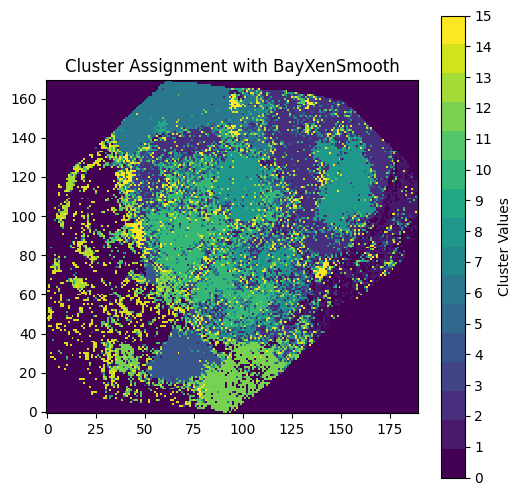

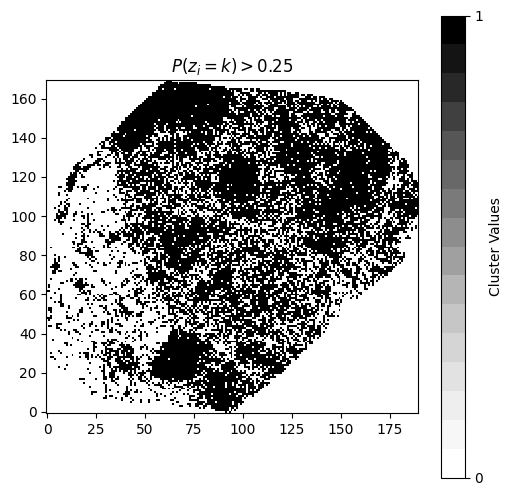

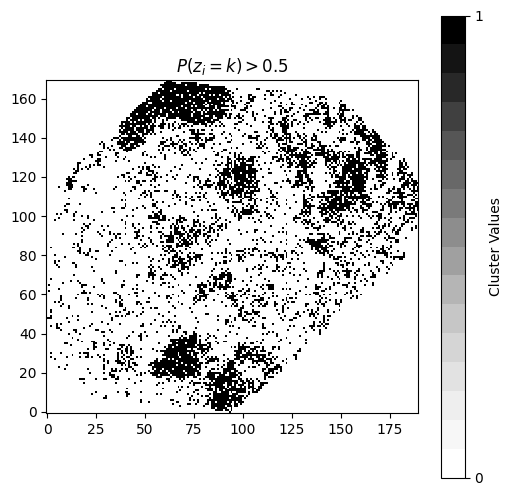

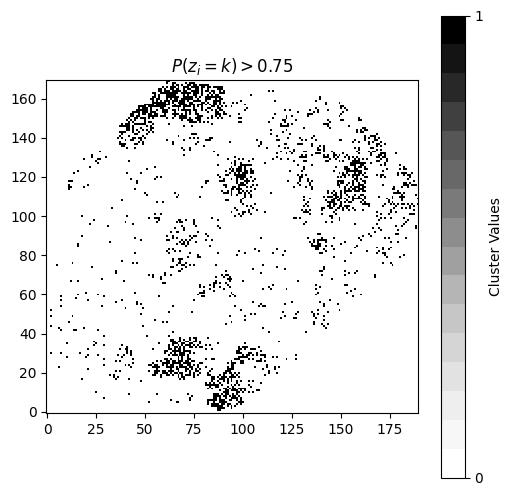

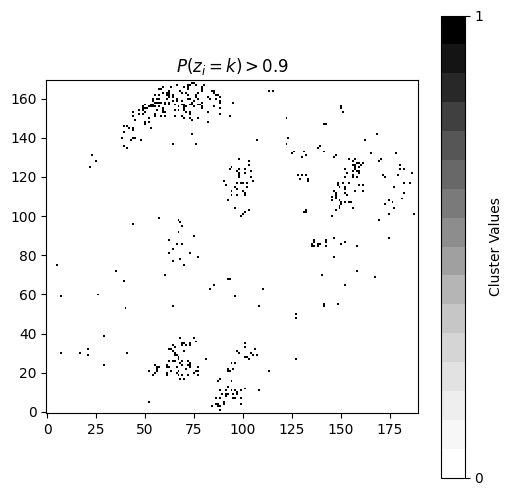

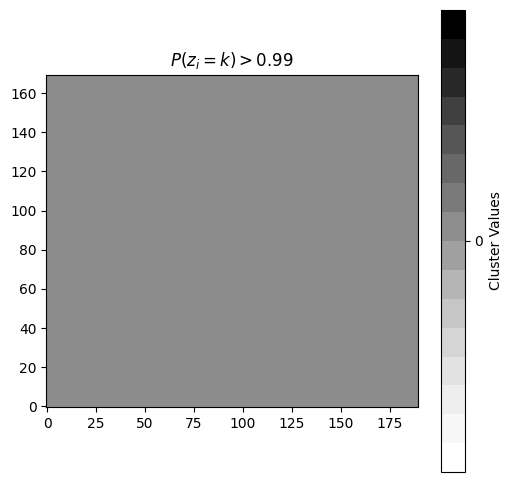

In [40]:
# Grab the learned variational parameters
cluster_concentration_params_q = pyro.param("cluster_concentration_params_q")
if sample_for_assignment:
    sampled_concentrations = pyro.sample("sampled_concentrations", dist.Normal(cluster_concentration_params_q, torch.ones_like(cluster_concentration_params_q)).to_event(1))
    cluster_probs_q = sampled_concentrations.softmax(dim=1) 
else:
    # the probs aren't sampled and we calculate the EV instead
    cluster_probs_q = cluster_concentration_params_q.softmax(dim=1)
cluster_assignments_q = cluster_probs_q.argmax(dim=1)

cluster_concentration_params_q = cluster_concentration_params_q.detach()
cluster_means_q = pyro.param("cluster_means_q").detach()
cluster_scales_q = pyro.param("cluster_scales_q").detach()

# Plotting
if spot_size:

    rows = spatial_locations["row"].astype(int)
    columns = spatial_locations["col"].astype(int)

    num_rows = int(max(rows) - min(rows) + 1)
    num_cols = int(max(columns) - min(columns) + 1)

    cluster_grid = torch.zeros((num_rows, num_cols), dtype=torch.long)

    cluster_grid[rows, columns] = cluster_assignments_q + 1

    colors = plt.cm.get_cmap('viridis', num_clusters + 1)
    colormap = ListedColormap(colors(np.linspace(0, 1, num_clusters + 1)))

    plt.figure(figsize=(6, 6))
    plt.imshow(cluster_grid, cmap=colormap, interpolation='nearest', origin='lower')
    plt.colorbar(ticks=range(num_clusters + 1), label='Cluster Values')
    plt.title('Cluster Assignment with BayXenSmooth')

    match data_mode:
        case "PCA":
            data_file_path = f"{data_mode}/{num_pcs}"
        case "HVG": 
            data_file_path = f"{data_mode}/{hvg_var_prop}"
        case "ALL":
            data_file_path = f"{data_mode}"
        case _:
            raise ValueError("The data mode specified is not supported.")

    if not os.path.exists(f"results/{dataset_name}/BayXenSmooth/clusters/{data_file_path}"):
        os.makedirs(f"results/{dataset_name}/BayXenSmooth/clusters/{data_file_path}")
    plt.savefig(
        f"results/{dataset_name}/BayXenSmooth/clusters/{data_file_path}/"
        f"KMEANSINIT={kmeans_init}_NEIGHBORSIZE={neighborhood_size}_NUMCLUSTERS={num_clusters}"
        f"_SPATIALINIT={spatial_init}_SAMPLEFORASSIGNMENT={sample_for_assignment}"
        f"_SPATIALNORM={spatial_normalize}_SPATIALPRIORMULT={concentration_amplification}_SPOTSIZE={spot_size}"
        f".png"
    )

    # grab the WSS distance of cluster labels
    wss = {}
    for label in range(1, num_clusters + 1):
        current_cluster_locations = torch.stack(torch.where((cluster_grid == label)), axis=1).to(float)
        wss[f"Cluster {label}"] = (spot_size ** 2) * torch.mean(torch.cdist(current_cluster_locations, current_cluster_locations)).item()

    if not os.path.exists(f"results/{dataset_name}/BayXenSmooth/wss/{data_file_path}/"):
        os.makedirs(f"results/{dataset_name}/BayXenSmooth/wss/{data_file_path}/")
    with open(f"results/{dataset_name}/BayXenSmooth/wss/{data_file_path}/"
        f"KMEANSINIT={kmeans_init}_NEIGHBORSIZE={neighborhood_size}_NUMCLUSTERS={num_clusters}"
        f"_SPATIALINIT={spatial_init}_SAMPLEFORASSIGNMENT={sample_for_assignment}"
        f"_SPATIALNORM={spatial_normalize}_SPATIALPRIORMULT={concentration_amplification}_SPOTSIZE={spot_size}"
        f".json", 'w') as fp:
        json.dump(wss, fp)

    cmap = get_cmap('rainbow')

    if isinstance(original_adata.xenium_spot_data.X, csr_matrix):
        labels = np.unique(cluster_assignments_q)  # Define the number of clusters
        gene_columns = original_adata.xenium_spot_data.var.index  # Column names from another source
        mean_expression_by_cluster = pd.DataFrame(columns=gene_columns)

        # Loop through each cluster label
        for label in labels:
            # Find indexes of current cluster
            current_cluster_indexes = torch.where(cluster_assignments_q == label)[0].numpy()
            
            # Efficiently extract the rows for the current cluster using fancy indexing
            expressions = original_adata.xenium_spot_data.X[current_cluster_indexes, :]
            print(label, expressions.shape)
            
            # Compute mean expressions; the result is still a csr_matrix
            mean_expressions = expressions.mean(axis=0)
            
            # Convert mean_expressions to a dense format and then to a DataFrame
            mean_expressions_df = pd.DataFrame(mean_expressions.A, columns=gene_columns)
            
            # Append the result to the mean_expression_by_cluster DataFrame
            mean_expression_by_cluster = pd.concat([mean_expression_by_cluster, mean_expressions_df], ignore_index=True)
    else:
        # identify marker genes within each cluster
        mean_expression_by_cluster = pd.DataFrame(columns=original_adata.xenium_spot_data.var.index)

        for label in range(num_clusters):
            current_cluster_indexes = list(torch.where(cluster_assignments_q == label)[0])
            expressions = pd.DataFrame(original_adata.xenium_spot_data.X, columns=original_adata.xenium_spot_data.var.index).iloc[current_cluster_indexes, :]
            mean_expressions = expressions.mean(axis=0).to_frame().T
            mean_expression_by_cluster = pd.concat([mean_expression_by_cluster, mean_expressions], ignore_index=True)

    if evaluate_markers:
        for i, gene in enumerate(mean_expression_by_cluster.columns):
            # using subplots() to draw vertical lines 
            fig, ax = plt.subplots(figsize=(6, 6)) 
            ax.vlines(mean_expression_by_cluster[gene].index, ymin=0, ymax=mean_expression_by_cluster[gene], color=cmap(i / (len(mean_expression_by_cluster.columns) - 1))) 
            
            # drawing the markers
            ax.plot(mean_expression_by_cluster[gene].index, mean_expression_by_cluster[gene], "^", c=cmap(i / (len(mean_expression_by_cluster.columns) - 1))) 
            ax.set_ylim(0) 
            
            # formatting and details 
            ax.set_xlabel('Cluster Label') 
            ax.set_ylabel('Mean Expression') 
            ax.set_title(gene) 
            ax.set_xticks(mean_expression_by_cluster[gene].index) 
            if not os.path.exists(f"results/{dataset_name}/BayXenSmooth/expressions/{data_file_path}/"):
                os.makedirs(f"results/{dataset_name}/BayXenSmooth/expressions/{data_file_path}/")
            plt.savefig(
                f"results/{dataset_name}/BayXenSmooth/expressions/{data_file_path}/"
                f"KMEANSINIT={kmeans_init}_NEIGHBORSIZE={neighborhood_size}_NUMCLUSTERS={num_clusters}"
                f"_SPATIALINIT={spatial_init}_SAMPLEFORASSIGNMENT={sample_for_assignment}"
                f"_SPATIALNORM={spatial_normalize}_SPATIALPRIORMULT={concentration_amplification}_SPOTSIZE={spot_size}"
                f"_GENE={gene}.png"
            )
    
    # confidence mapping
    cluster_confidences = torch.zeros((num_rows, num_cols), dtype=torch.double)

    cluster_confidences[rows, columns] = cluster_probs_q.max(dim=1).values

    colors = plt.cm.get_cmap('Greys', num_clusters + 1)
    colormap = ListedColormap(colors(np.linspace(0, 1, num_clusters + 1)))

    confidence_proportions = {}
    for uncertainty_value in uncertainty_values:
        confidence_matrix = (cluster_confidences > uncertainty_value).float()
        confidence_proportions[uncertainty_value] = torch.mean(confidence_matrix).item()
        plt.figure(figsize=(6, 6))
        plt.imshow(cluster_confidences > uncertainty_value, cmap=colormap, interpolation='nearest', origin='lower')
        plt.colorbar(ticks=range(num_clusters + 1), label='Cluster Values')
        # PLOT ALL UNCERTAINTY VALUESs
        plt.title(r'$P(z_i = k) > $' + f'{uncertainty_value}')
        if not os.path.exists(bayxensmooth_uncertainty_filepath := save_filepath("BayXenSmooth", "uncertainty")):
            os.makedirs(bayxensmooth_uncertainty_filepath)
        plt.savefig(
            f"{bayxensmooth_uncertainty_filepath}/CONFIDENCE={uncertainty_value}.png"
        )

else:

    plt.scatter(spatial_locations["x_location"], spatial_locations["y_location"], s=1, c=cluster_assignments_q)
    if not os.path.exists(bayxensmooth_clusters_filepath := save_filepath("BayXenSmooth", "clusters")):
        os.makedirs(bayxensmooth_clusters_filepath)
    plt.savefig(
        f"{bayxensmooth_clusters_filepath}/result.png"
    )

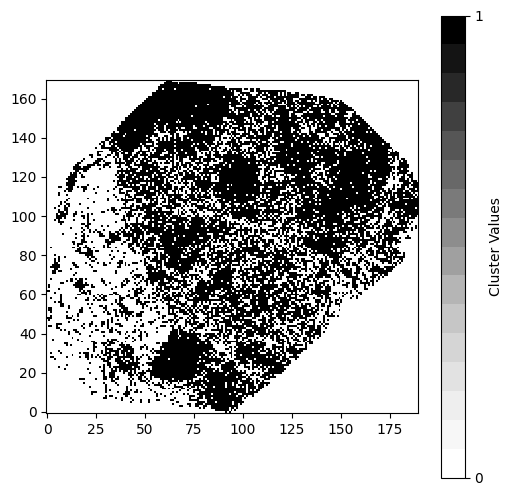

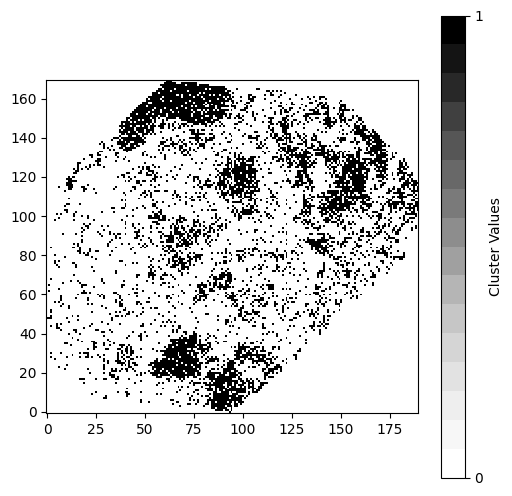

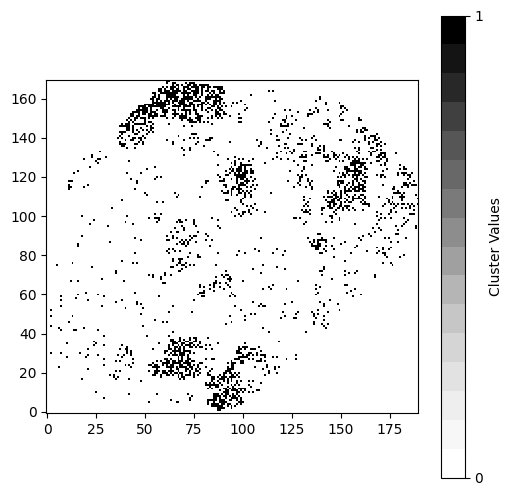

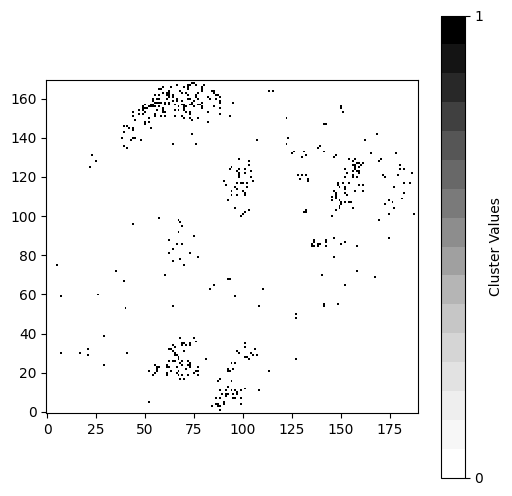

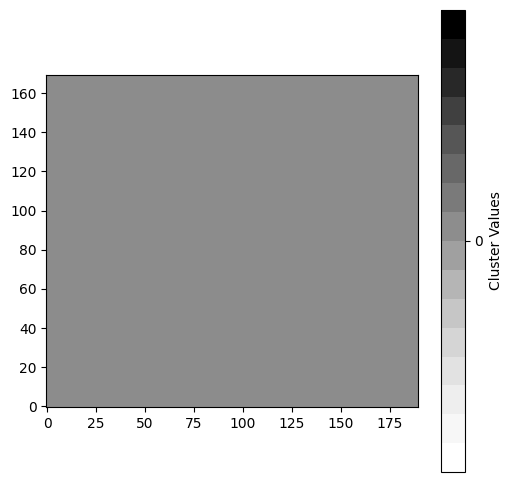

In [41]:
confidence_proportions = {}
for uncertainty_value in uncertainty_values:
    confidence_matrix = (cluster_confidences > uncertainty_value).float()
    confidence_proportions[uncertainty_value] = torch.mean(confidence_matrix).item()
    plt.figure(figsize=(6, 6))
    plt.imshow(confidence_matrix, cmap=colormap, interpolation='nearest', origin='lower')
    plt.colorbar(ticks=range(num_clusters + 1), label='Cluster Values')
    # PLOT ALL UNCERTAINTY VALUESs

In [42]:
print(f"results/{dataset_name}/BayXenSmooth/uncertainty/{data_file_path}/"
f"KMEANSINIT={kmeans_init}_NEIGHBORSIZE={neighborhood_size}_NUMCLUSTERS={num_clusters}"
f"_SPATIALINIT={spatial_init}_SAMPLEFORASSIGNMENT={sample_for_assignment}"
f"_SPATIALNORM={spatial_normalize}_SPATIALPRIORMULT={concentration_amplification}_SPOTSIZE={spot_size}"
f".json")

results/hBreast/BayXenSmooth/uncertainty/PCA/25/KMEANSINIT=True_NEIGHBORSIZE=2_NUMCLUSTERS=15_SPATIALINIT=True_SAMPLEFORASSIGNMENT=True_SPATIALNORM=1.0_SPATIALPRIORMULT=5_SPOTSIZE=50.json


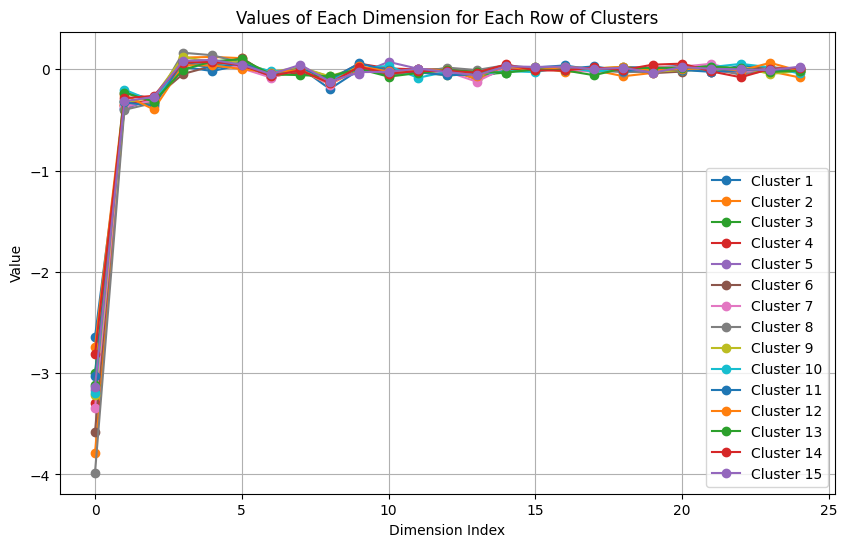

In [43]:
plt.figure(figsize=(10, 6))

for i, row in enumerate(cluster_means_q):
    row_values = row.numpy()
    plt.plot(row_values, marker='o', linestyle='-', label=f'Cluster {i+1}')

plt.title('Values of Each Dimension for Each Row of Clusters')
plt.xlabel('Dimension Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()
